# **Multi-Mapping Reads: Dataset Preparation**

### *Genome: E. coli*

* Strain: K-12 MG1655
* Downloaded: ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/005/845/GCF_000005845.2_ASM584v2/GCF_000005845.2_ASM584v2_genomic.fna.gz



# Environment Configuration

In [1]:
!pip install gensim
!pip install pysam pandas scikit-learn biopython
!pip install python-Levenshtein

import shutil
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from collections import defaultdict
import matplotlib.pyplot as plt
import pysam
from Bio import SeqIO
import pandas as pd
import json
from collections import defaultdict
import pysam
from tqdm.notebook import tqdm
import Levenshtein

plt.rcParams['font.family'] = 'serif'            # Use a specific font
plt.rcParams['font.size'] = 13                   # Set a general font size

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 26.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
mlxte

In [2]:
ROOT_DIR = os.path.join('/kaggle/working/', 'ecoli')
REF_DIR = os.path.join(ROOT_DIR, 'ref')
ALIGN_DIR = os.path.join(ROOT_DIR, 'align')
DATA_DIR = os.path.join(ROOT_DIR, 'data')

READ_LENGTH = 100
FOLD_COVERAGE = 30
MEAN_FRAG_SIZE = 300
SD_FRAG_SIZE = 10
MIN_INSERT = 280
MAX_INSERT = 320

In [3]:
# Install bowtie2 and samtools

!apt-get update -qq
!apt-get install -y bowtie2 samtools

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)



The following additional packages will be installed:
  libhts3 libhtscodecs2
Suggested packages:
  bowtie2-examples cwltool
The following NEW packages will be installed:
  bowtie2 libhts3 libhtscodecs2 samtools
0 upgraded, 4 newly installed, 0 to remove and 167 not upgraded.
Need to get 2,131 kB of archives.
After this operation, 6,005 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libhtscodecs2 amd64 1.1.1-3 [53.2 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libhts3 amd64 1.13+ds-2build1 [390 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 samtools amd64 1.13-4 [520 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 bowtie2 amd64 2.4.4-1 [1,169 kB]
Fetched 2,131 kB in 0s (15.4 MB/s)
Selecting pr

In [4]:
# Check installation

!bowtie2 --version | head -n 1
!samtools --version | head -n 1

/usr/bin/bowtie2-align-s version 2.4.4
samtools 1.13


In [5]:
# Organize dirs
shutil.rmtree(ROOT_DIR, ignore_errors=True)
os.makedirs(ROOT_DIR)

!mkdir -p {REF_DIR}
!mkdir -p {ALIGN_DIR}
!mkdir -p {DATA_DIR}

# Retrieve Reference Genome Sequence

In [6]:
# Download E. coli K-12 MG1655 reference genome
!wget -O $REF_DIR/ecoli_ref.fa.gz \
ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/005/845/GCF_000005845.2_ASM584v2/GCF_000005845.2_ASM584v2_genomic.fna.gz

# Unzip
!gunzip -f $REF_DIR/ecoli_ref.fa.gz

# Fix header so it matches SAM reference names
# SAM uses: NC_000913.3
!sed -i 's/^>.*NC_000913.3.*/>NC_000913.3/' $REF_DIR/ecoli_ref.fa

# Verify first few lines
!head -n 5 $REF_DIR/ecoli_ref.fa

--2025-09-20 04:26:48--  ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/005/845/GCF_000005845.2_ASM584v2/GCF_000005845.2_ASM584v2_genomic.fna.gz
           => ‘/kaggle/working/ecoli/ref/ecoli_ref.fa.gz’
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.31, 130.14.250.13, 130.14.250.7, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.31|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /genomes/all/GCF/000/005/845/GCF_000005845.2_ASM584v2 ... done.
==> SIZE GCF_000005845.2_ASM584v2_genomic.fna.gz ... 1379902
==> PASV ... done.    ==> RETR GCF_000005845.2_ASM584v2_genomic.fna.gz ... done.
Length: 1379902 (1.3M) (unauthoritative)

GCF_000005845.2_ASM 100%[===================>]   1.32M  2.02MB/s    in 0.7s    

2025-09-20 04:26:50 (2.02 MB/s) - ‘/kaggle/working/ecoli/ref/ecoli_ref.fa.gz’ saved [1379902]

>NC_000913.3
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAA

In [7]:
## Chromosome statistics 

# Parse the fasta file
fasta_file = os.path.join(REF_DIR, 'ecoli_ref.fa')
records = SeqIO.parse(fasta_file, "fasta")

rows = []
for record in records:
    seq = str(record.seq).upper()
    length = len(seq)
    
    # Count bases
    base_counts = {
        "A": seq.count("A"),
        "C": seq.count("C"),
        "G": seq.count("G"),
        "T": seq.count("T"),
        "N": seq.count("N")  # unknown bases
    }
    
    rows.append({
        "Chromosome": record.id,
        "Start": 1,
        "End": length,
        "Length": length,
        **base_counts
    })

# Convert to DataFrame
pd.DataFrame(rows)

,Chromosome,Start,End,Length,A,C,G,T,N
0,NC_000913.3,1,4641652,4641652,1142742,1180091,1177437,1141382,0


In [8]:
# Indexing reference

!bowtie2-build {REF_DIR}/ecoli_ref.fa {REF_DIR}/ecoli_ref_index

Settings:
  Output files: "/kaggle/working/ecoli/ref/ecoli_ref_index.*.bt2"
  Line rate: 6 (line is 64 bytes)
  Lines per side: 1 (side is 64 bytes)
  Offset rate: 4 (one in 16)
  FTable chars: 10
  Strings: unpacked
  Max bucket size: default
  Max bucket size, sqrt multiplier: default
  Max bucket size, len divisor: 4
  Difference-cover sample period: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 0
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  /kaggle/working/ecoli/ref/ecoli_ref.fa
Building a SMALL index
Reading reference sizes
  Time reading reference sizes: 00:00:00
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences
  Time to join reference sequences: 00:00:00
bmax according to bmaxDivN setting: 1160413
Using parameters --bmax 870310 --dcv 1024
  Doing ahead-of-time memory usage test
  Passed!  Constructing with these parameters

# Read Simulation

In [9]:
# Install illumina

!sudo apt-get install art-nextgen-simulation-tools




The following additional packages will be installed:
  libgsl27 libgslcblas0
Suggested packages:
  art-nextgen-simulation-tools-profiles gsl-ref-psdoc | gsl-doc-pdf
  | gsl-doc-info | gsl-ref-html
The following NEW packages will be installed:
  art-nextgen-simulation-tools libgsl27 libgslcblas0
0 upgraded, 3 newly installed, 0 to remove and 167 not upgraded.
Need to get 2,846 kB of archives.
After this operation, 12.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libgslcblas0 amd64 2.7.1+dfsg-3 [94.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libgsl27 amd64 2.7.1+dfsg-3 [1,000 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 art-nextgen-simulation-tools amd64 20160605+dfsg-4build2 [1,751 kB]
Fetched 2,846 kB in 2s (1,648 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/De

In [10]:
# Paired-end reads + truths

!art_illumina -ss HS25 -sam -i {REF_DIR}/ecoli_ref.fa -p -l {READ_LENGTH} -f {FOLD_COVERAGE} -m {MEAN_FRAG_SIZE} -s {SD_FRAG_SIZE} -o {REF_DIR}/ecoli  -rs 1234


    ====================ART====================
             ART_Illumina (2008-2016)          
          Q Version 2.5.8 (June 6, 2016)       
     Contact: Weichun Huang <whduke@gmail.com> 
    -------------------------------------------

                  Paired-end sequencing simulation

Total CPU time used: 36.8203

The random seed for the run: 1234

Parameters used during run
	Read Length:	100
	Genome masking 'N' cutoff frequency: 	1 in 100
	Fold Coverage:            30X
	Mean Fragment Length:     300
	Standard Deviation:       10
	Profile Type:             Combined
	ID Tag:                   

Quality Profile(s)
	First Read:   HiSeq 2500 Length 126 R1 (built-in profile) 
	First Read:   HiSeq 2500 Length 126 R2 (built-in profile) 

Output files

  FASTQ Sequence Files:
	 the 1st reads: /kaggle/working/ecoli/ref/ecoli1.fq
	 the 2nd reads: /kaggle/working/ecoli/ref/ecoli2.fq

  ALN Alignment Files:
	 the 1st reads: /kaggle/working/ecoli/ref/ecoli1.aln
	 the 2nd reads: /kaggle/work

# Aligning Reads

In [11]:
# Using Bowtie: report multiple

!bowtie2 -x {REF_DIR}/ecoli_ref_index -1 {REF_DIR}/ecoli1.fq -2 {REF_DIR}/ecoli2.fq \
  -I {MIN_INSERT} -X {MAX_INSERT} \
  -S {ALIGN_DIR}/ecoli_bowtie.sam -a --very-sensitive \
  --seed 1234

696240 reads; of these:
  696240 (100.00%) were paired; of these:
    28309 (4.07%) aligned concordantly 0 times
    652814 (93.76%) aligned concordantly exactly 1 time
    15117 (2.17%) aligned concordantly >1 times
    ----
    28309 pairs aligned concordantly 0 times; of these:
      27315 (96.49%) aligned discordantly 1 time
    ----
    994 pairs aligned 0 times concordantly or discordantly; of these:
      1988 mates make up the pairs; of these:
        0 (0.00%) aligned 0 times
        339 (17.05%) aligned exactly 1 time
        1649 (82.95%) aligned >1 times
100.00% overall alignment rate


In [12]:
# Using Bowtie: report single

!bowtie2 -x {REF_DIR}/ecoli_ref_index -1 {REF_DIR}/ecoli1.fq -2 {REF_DIR}/ecoli2.fq \
  -I {MIN_INSERT} -X {MAX_INSERT} \
  -S {ALIGN_DIR}/ecoli_bowtie_selected.sam --very-sensitive \
  --seed 1234

696240 reads; of these:
  696240 (100.00%) were paired; of these:
    28309 (4.07%) aligned concordantly 0 times
    652817 (93.76%) aligned concordantly exactly 1 time
    15114 (2.17%) aligned concordantly >1 times
    ----
    28309 pairs aligned concordantly 0 times; of these:
      27318 (96.50%) aligned discordantly 1 time
    ----
    991 pairs aligned 0 times concordantly or discordantly; of these:
      1982 mates make up the pairs; of these:
        0 (0.00%) aligned 0 times
        336 (16.95%) aligned exactly 1 time
        1646 (83.05%) aligned >1 times
100.00% overall alignment rate


# Filtering Multi-Mapping Reads

In [13]:
align_sam_path = os.path.join(ALIGN_DIR, 'ecoli_bowtie.sam')
truth_sam_path = os.path.join(REF_DIR, 'ecoli.sam')
ref_path = os.path.join(REF_DIR, 'ecoli_ref.fa')

In [14]:
def build_truth_dict(truth_sam_path, ref_path):
    ref = pysam.FastaFile(ref_path)
    truth_sam = pysam.AlignmentFile(truth_sam_path, "r", check_sq=False)
    
    # Collect all alignments by query name
    truth_dict = {}
    for aln in truth_sam.fetch(until_eof=True):
        chr_name = aln.reference_name
        qname = aln.query_name
        read_num = 1 if aln.is_read1 else 2
        start, end = aln.reference_start, aln.reference_end
    
        # Sanity checks
        if chr_name is None: print('[E]: chr=None')
        if start is None: print('[E]: start=None')
        if end is None: print('[E]: end=None')
    
        truth_dict.setdefault(qname, []).append((read_num, chr_name, start, end))
    
    truth_sam.close()
    
    # Construct mate pairs
    paired_truth_dict = {}
    for qname, alns in truth_dict.items():
        r1_entries = [aln for aln in alns if aln[0] == 1]
        r2_entries = [aln for aln in alns if aln[0] == 2]
    
        # Ensure that truth data contains exactly one alignment per mate
        assert len(r1_entries) == 1 and len(r2_entries) == 1
        r1, r2 = r1_entries[0], r2_entries[0]
        
        # Verify both mates are aligned to the same chromosome
        assert r1[1] == r2[1]
        r1_chr = r1[1]
        
        r1_start, r1_end = r1[2], r1[3]
        r2_start, r2_end = r2[2], r2[3]
    
        # Fetch reference sequence spanning both mates
        seq = ref.fetch(r1_chr, min(r1_start, r2_start), max(r1_end, r2_end))
    
        paired_truth_dict[qname] = {
            'chr': r1_chr, 
            'r1_start': r1_start, 
            'r1_end': r1_end, 
            'r2_start': r2_start, 
            'r2_end': r2_end, 
            'seq': seq
        }
        
    ref.close()
    print(f"Truth dict size: {len(paired_truth_dict)}")
    return paired_truth_dict

# Prepare ground truth dictionary
truth_dict = build_truth_dict(truth_sam_path, ref_path)

Truth dict size: 696240


In [15]:
def load_bowtie_selected_dict(selected_sam_path):
    """
    Returns a dict: {qname: set of (chr, r1_start, r1_end, r2_start, r2_end)}
    from the Bowtie2 run without -a (the chosen alignments).
    """
    selected = {}
    with pysam.AlignmentFile(selected_sam_path, "r", check_sq=False) as f:
        tmp = {}
        for aln in f.fetch(until_eof=True):
            if not aln.is_proper_pair:
                continue
            q = aln.query_name
            rnum = 1 if aln.is_read1 else 2
            tmp.setdefault(q, {})[rnum] = aln
        for q, mates in tmp.items():
            if 1 in mates and 2 in mates:
                r1, r2 = mates[1], mates[2]
                if r1.reference_name == r2.reference_name:
                    sig = (
                        r1.reference_name,
                        r1.reference_start, r1.reference_end,
                        r2.reference_start, r2.reference_end
                    )
                    selected.setdefault(q, set()).add(sig)
        print(f"Selected dict size: {len(selected)}")
    return selected

# Prepare bowtie selected dictionary
selected_dict = load_bowtie_selected_dict(f"{ALIGN_DIR}/ecoli_bowtie_selected.sam")

Selected dict size: 667931


In [16]:
def get_concordant_pairs(align_sam_path, ref_path):
    ''' Returns exact (concordant once) and multi-mapping (concordant > 1) reads (paired)
    '''
    ref = pysam.FastaFile(ref_path)
    align_sam = pysam.AlignmentFile(align_sam_path, "r", check_sq=False)

    # Collect concordant alignments by query name
    align_dict = {}
    for aln in align_sam.fetch(until_eof=True):
        if not aln.is_proper_pair:
            continue

        chr_name = aln.reference_name
        qname = aln.query_name
        read_num = 1 if aln.is_read1 else 2
        start, end = aln.reference_start, aln.reference_end

        # Sanity checks
        if chr_name is None: print('[E]: chr=None')
        if start is None: print('[E]: start=None')
        if end is None: print('[E]: end=None')

        align_dict.setdefault(qname, []).append((read_num, chr_name, start, end, aln))

    align_sam.close()

    # Make paired alignments
    paired_alns = []
    paired_one_alns = []
    with tqdm(total=len(align_dict)) as pbar:
        for qname, alns in align_dict.items():
            pbar.update(1)
            r1_entries = [aln for aln in alns if aln[0] == 1]
            r2_entries = [aln for aln in alns if aln[0] == 2]
            
            # Must have equal number of entries
            assert len(r1_entries) == len(r2_entries)
            if len(r1_entries) == 1:
                # Single align
                r1, r2 = r1_entries[0], r2_entries[0]
                assert r1[4].next_reference_start == r2[2] and r2[4].next_reference_start == r1[2]
                # Chromosome sanity check
                assert r1[1] == r2[1]
                seq = ref.fetch(r1[1], min(r1[2], r2[2]), max(r1[3], r2[3]))
                paired_one_alns.append({
                    'qname': qname,
                    'chr': r1[1],
                    'r1_start': r1[2],
                    'r1_end': r1[3],
                    'r2_start': r2[2],
                    'r2_end': r2[3], 
                    'r1_mapq': r1[4].mapping_quality, 
                    'r2_mapq': r2[4].mapping_quality, 
                    'r1_flag': r1[4].flag, 
                    'r2_flag': r2[4].flag, 
                    'r1_is_reverse': r1[4].is_reverse, 
                    'r2_is_reverse': r2[4].is_reverse, 
                    'r1_primary': not (r1[4].is_secondary or r1[4].is_supplementary), 
                    'r2_primary': not (r2[4].is_secondary or r2[4].is_supplementary), 
                    'tfidf_k6': None, 
                    'tfidf_k7': None, 
                    'tfidf_k8': None, 
                    'tfidf_k9': None, 
                    'tfidf_k10': None, 
                    'tfidf_k11': None, 
                    'tfidf_k12': None, 
                    'tfidf_k13': None, 
                    'tfidf_k14': None, 
                    'tfidf_k15': None, 
                    'weight': 0, 
                    'p_val': 0, 
                    'z_score': 0, 
                    'seq': seq, 
                    'label': True, 
                    # Retrieve bowtie's selected alignment for this qname (read)
                    'bowtie': (r1[1], r1[2], r1[3], r2[2], r2[3]) in selected_dict.get(qname, set())
                })
            else:
                for r1 in r1_entries:
                    for r2 in r2_entries:
                        # Check mate positions
                        if r1[4].next_reference_start == r2[2] and r2[4].next_reference_start == r1[2]:
                            # Chromosome sanity check
                            assert r1[1] == r2[1]
                            seq = ref.fetch(r1[1], min(r1[2], r2[2]), max(r1[3], r2[3]))
        
                            paired_alns.append({
                                'qname': qname,
                                'chr': r1[1],
                                'r1_start': r1[2],
                                'r1_end': r1[3],
                                'r2_start': r2[2],
                                'r2_end': r2[3], 
                                'r1_mapq': r1[4].mapping_quality, 
                                'r2_mapq': r2[4].mapping_quality, 
                                'r1_flag': r1[4].flag, 
                                'r2_flag': r2[4].flag, 
                                'r1_is_reverse': r1[4].is_reverse, 
                                'r2_is_reverse': r2[4].is_reverse, 
                                'r1_primary': not (r1[4].is_secondary or r1[4].is_supplementary), 
                                'r2_primary': not (r2[4].is_secondary or r2[4].is_supplementary), 
                                'tfidf_k6': None, 
                                'tfidf_k7': None, 
                                'tfidf_k8': None, 
                                'tfidf_k9': None, 
                                'tfidf_k10': None, 
                                'tfidf_k11': None, 
                                'tfidf_k12': None, 
                                'tfidf_k13': None, 
                                'tfidf_k14': None, 
                                'tfidf_k15': None, 
                                'weight': 0, 
                                'p_val': 0, 
                                'z_score': 0, 
                                'seq': seq, 
                                'label': False, 
                                # Retrieve bowtie's selected alignment for this qname (read)
                                'bowtie': (r1[1], r1[2], r1[3], r2[2], r2[3]) in selected_dict.get(qname, set())
                            })

    ref.close()
    return paired_one_alns, paired_alns


In [17]:
paired_exact_alns, paired_multi_alns = get_concordant_pairs(align_sam_path, ref_path)
print(f'Paired: exactly={len(paired_exact_alns)}, ambiguous={len(paired_multi_alns)}')

  0%|          | 0/667931 [00:00<?, ?it/s]

Paired: exactly=652814, ambiguous=82805


In [18]:
from difflib import SequenceMatcher

def longest_common_substring(str1: str, str2: str) -> str:
    """
    Returns the longest common substring between str1 and str2.
    If no common substring exists, returns an empty string.
    """
    match = SequenceMatcher(None, str1, str2).find_longest_match(0, len(str1), 0, len(str2))
    if match.size == 0:
        return ""
    return str1[match.a: match.a + match.size]

def reverse_complement(seq):
    complement = str.maketrans('ACGTNacgtn', 'TGCANtgcan')
    return seq.translate(complement)[::-1]


In [19]:
# Assign labels against dictionary 
for aln in paired_multi_alns:
    qname = aln['qname']
    chromosome = aln['chr']
    r1_start = aln['r1_start']
    r1_end = aln['r1_end']
    r2_start = aln['r2_start']
    r2_end = aln['r2_end']
    seq = aln['seq']

    # Match truth?
    truth_align = truth_dict[qname]
    if truth_align and truth_align['chr'] == chromosome and ((seq in truth_align['seq']) or (truth_align['seq'] in seq) or (reverse_complement(seq) in truth_align['seq']) or (reverse_complement(truth_align['seq']) in seq)): # len(longest_common_substring(seq, truth_align['seq'])) >= len(seq)-100
        aln['label'] = True
    else:
        aln['label'] = False


In [20]:
_total_exact, _total = len(paired_exact_alns), len(paired_multi_alns)
_incorrect_exact = len([pair for pair in paired_exact_alns if not pair['label']])
_incorrect = len([pair for pair in paired_multi_alns if not pair['label']])
_bowtie_error = len([pair for pair in paired_multi_alns if not pair['label'] and pair['bowtie']])
_bowtie_correct = len([pair for pair in paired_multi_alns if pair['bowtie']])
print('# Unique pairs:')
print(f'Total={_total_exact}, Correct={_total_exact - _incorrect_exact}, Incorrect={_incorrect_exact}')
print('\n# Ambiguous pairs:')
print(f'Total={_total}, Correct={_total - _incorrect}, Incorrect={_incorrect}')
print('\n# Bowtie error:')
print(f'Correct={_bowtie_correct}, Actually={_bowtie_correct - _bowtie_error}, Error={_bowtie_error}')

# Unique pairs:
Total=652814, Correct=652814, Incorrect=0

# Ambiguous pairs:
Total=82805, Correct=53805, Incorrect=29000

# Bowtie error:
Correct=15117, Actually=14389, Error=728


# TF-IDF Statistics

In [21]:
## Extracts all sequences from the ref. and sample

from sklearn.utils import resample
import numpy as np

# Reverse complement helper
def rev_comp(seq: str) -> str:
    comp = str.maketrans("ACGTN", "TGCAN")
    return seq.translate(comp)[::-1]

# Pulling sequences
exact_aln_seqs = []
for pair in paired_exact_alns:
    exact_aln_seqs.append(pair['seq'])

print('Total:', len(exact_aln_seqs))

N_SAMPLES = (len(exact_aln_seqs))

Total: 652814


In [22]:
import math
from collections import Counter

# ========= Helper: map a k-mer to index =========
def map_kmer_to_index(kmer: str) -> int:
    """
    Convert a k-mer (string of A/C/G/T) into an integer index (base-4 encoding).
    A=0, C=1, G=2, T=3
    """
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    idx = 0
    for base in kmer:
        idx = (idx << 2) | mapping[base]   # shift left 2 bits, add value
    return idx

# ========= Precompute DF array =========
def compute_df_array(reads, k=10):
    """
    Compute document frequency (DF) array for all possible k-mers.
    reads: list of strings (each string = one read/sequence)
    k: k-mer length (default 10)

    Returns:
        df_array: np.ndarray of size 4^k, where df_array[i] = #docs containing that k-mer
    """
    vocab_size = 4 ** k
    df_array = np.zeros(vocab_size, dtype=np.int32)

    for read in reads:
        kmers_in_doc = set()
        for i in range(len(read) - k + 1):
            kmer = read[i:i+k]
            if 'N' in kmer:  # skip ambiguous bases
                continue
            idx = map_kmer_to_index(kmer)
            kmers_in_doc.add(idx)

        # Update DF counts
        for idx in kmers_in_doc:
            df_array[idx] += 1

    return df_array

def seq_kmer_tfidf_vector_array(seq: str, df_array: np.ndarray, n_docs: int, k: int) -> list[float]:
    """
    Build k-mers from `seq` only, compute TF in `seq`,
    retrieve DF from precomputed df_array, and return TF-IDF vector.
    """
    kmers_seq = [seq[i:i+k] for i in range(len(seq) - k + 1) if 'N' not in seq[i:i+k]]
    if not kmers_seq:
        return []

    # TF in seq (per unique k-mer)
    counts = Counter(kmers_seq)
    total = len(kmers_seq)
    tf = {km: counts[km] / total for km in counts}

    # Build TF-IDF vector aligned to each k-mer occurrence in seq
    vec = []
    for km in kmers_seq:
        idx = map_kmer_to_index(km)  # use your existing method
        df_km = df_array[idx] if idx < len(df_array) else 0
        idf_km = math.log((n_docs + 1) / (df_km + 1)) + 1
        vec.append(tf[km] * idf_km)

    return vec


In [23]:
## Pre-compute df values for faster execution (required)

df_array_k6 = compute_df_array(exact_aln_seqs, k=6)

In [24]:
df_array_k7 = compute_df_array(exact_aln_seqs, k=7)

In [25]:
df_array_k8 = compute_df_array(exact_aln_seqs, k=8)

In [26]:
df_array_k9 = compute_df_array(exact_aln_seqs, k=9)

In [27]:
df_array_k10 = compute_df_array(exact_aln_seqs, k=10)

In [28]:
df_array_k11 = compute_df_array(exact_aln_seqs, k=11)

In [29]:
df_array_k12 = compute_df_array(exact_aln_seqs, k=12)

In [30]:
df_array_k13 = compute_df_array(exact_aln_seqs, k=13)

In [31]:
df_array_k14 = compute_df_array(exact_aln_seqs, k=14)

In [32]:
df_array_k15 = compute_df_array(exact_aln_seqs, k=15)

In [33]:
def trim_seq_to_size(s: str, target_size: int) -> str:
    start = (len(s) - target_size) // 2
    return s[start:start + target_size]

# Calculating minimum sequence length
seq_len = min([len(pair['seq']) for pair in paired_exact_alns + paired_multi_alns]) - READ_LENGTH
print(f'Min sequence length: {seq_len}')

# Generating tfidfs from ambiguous
with tqdm(total=len(paired_multi_alns)) as pbar: 
    for pair in paired_multi_alns:
        pair['tfidf_k6'] = seq_kmer_tfidf_vector_array(trim_seq_to_size(pair['seq'], target_size=seq_len), df_array_k6, N_SAMPLES, k=6) 
        pair['tfidf_k7'] = seq_kmer_tfidf_vector_array(trim_seq_to_size(pair['seq'], target_size=seq_len), df_array_k7, N_SAMPLES, k=7) 
        pair['tfidf_k8'] = seq_kmer_tfidf_vector_array(trim_seq_to_size(pair['seq'], target_size=seq_len), df_array_k8, N_SAMPLES, k=8) 
        pair['tfidf_k9'] = seq_kmer_tfidf_vector_array(trim_seq_to_size(pair['seq'], target_size=seq_len), df_array_k9, N_SAMPLES, k=9) 
        pair['tfidf_k10'] = seq_kmer_tfidf_vector_array(trim_seq_to_size(pair['seq'], target_size=seq_len), df_array_k10, N_SAMPLES, k=10) 
        pair['tfidf_k11'] = seq_kmer_tfidf_vector_array(trim_seq_to_size(pair['seq'], target_size=seq_len), df_array_k11, N_SAMPLES, k=11) 
        pair['tfidf_k12'] = seq_kmer_tfidf_vector_array(trim_seq_to_size(pair['seq'], target_size=seq_len), df_array_k12, N_SAMPLES, k=12) 
        pair['tfidf_k13'] = seq_kmer_tfidf_vector_array(trim_seq_to_size(pair['seq'], target_size=seq_len), df_array_k13, N_SAMPLES, k=13) 
        pair['tfidf_k14'] = seq_kmer_tfidf_vector_array(trim_seq_to_size(pair['seq'], target_size=seq_len), df_array_k14, N_SAMPLES, k=14) 
        pair['tfidf_k15'] = seq_kmer_tfidf_vector_array(trim_seq_to_size(pair['seq'], target_size=seq_len), df_array_k15, N_SAMPLES, k=15) 
        pbar.update(1)


Min sequence length: 180


  0%|          | 0/82805 [00:00<?, ?it/s]

In [34]:
#===========================================================================================
#======================================== EXAMPLE ==========================================
#===========================================================================================

for pair in paired_multi_alns[:5]: 
    print(pair['qname'])
    v = pair['tfidf_k10']
    print('length:', len(pair['seq']), len(v))


NC_000913.3-1392422
length: 291 171
NC_000913.3-1392422
length: 291 171
NC_000913.3-1392422
length: 291 171
NC_000913.3-1392422
length: 291 171
NC_000913.3-1392422
length: 291 171


# Weighting: Probability of Reads

In [35]:
def build_coverage_array(ref_path, mapped_pairs):
    ref = pysam.FastaFile(ref_path)
    chrom_len = {chrom: ref.get_reference_length(chrom) for chrom in ref.references}['NC_000913.3']
    cvg_arr = np.zeros(chrom_len, dtype=np.int32)
    
    for pair in mapped_pairs:
        # Get start of fragment = min of both starts
        frag_start = min(pair['r1_start'], pair['r2_start'])
        # Get end of fragment = max of both ends
        frag_end = max(pair['r1_end'], pair['r2_end'])
        
        # Add coverage (end is exclusive in numpy slicing)
        cvg_arr[frag_start:frag_end] += 1
    
    return cvg_arr

def plot_hist_from_counts(cvg_arr, step=100):
    plt.figure(figsize=(12,4))
    plt.plot(cvg_arr, linewidth=0.5)
    plt.xlabel("Genomic Position")
    plt.ylabel("Coverage")
    plt.title("Coverage along the genome")
    plt.show()

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_coverage_heatmap(cvg_arr, bin_size=100, cmap='viridis'):
    """
    Plots coverage as a binned heatmap.
    
    Parameters:
        cvg_arr : array-like
            Coverage values along the genome.
        bin_size : int
            Number of genomic positions per bin.
        cmap : str
            Colormap for heatmap.
    """
    # Calculate number of bins
    n_bins = int(np.ceil(len(cvg_arr) / bin_size))
    
    # Aggregate coverage within bins (mean)
    binned = [np.max(cvg_arr[i*bin_size:(i+1)*bin_size]) for i in range(n_bins)]
    binned = np.array(binned)
    
    # Reshape to 2D for heatmap (1 row)
    heatmap_data = binned[np.newaxis, :]
    
    plt.figure(figsize=(15, 1))
    plt.imshow(heatmap_data, aspect='auto', cmap=cmap, origin='lower',
               vmin=0, vmax=np.max(binned))
    plt.colorbar(label="Coverage")
    plt.xlabel(f"Genomic Position (bin size = {bin_size} bases)")
    plt.yticks([])  # hide y-axis
    plt.title("Read Coverage")
    plt.show()

def aggregate_region_stats_weighted(df, region_start, region_end):
    overlaps = df[(df['start'] <= region_end) & (df['end'] >= region_start)].copy()
    if overlaps.empty:
        return {"total_overlap": 0, "gene_ids": [], "z_score": np.nan, "p_value": np.nan}
    
    overlaps['overlap_len'] = overlaps.apply(
        lambda row: max(0, min(row['end'], region_end) - max(row['start'], region_start)),
        axis=1
    )
    total_overlap = overlaps['overlap_len'].sum()
    if total_overlap == 0:
        return {"total_overlap": 0, "gene_ids": [], "z_score": np.nan, "p_value": np.nan}

    # Weighted z-score aggregation
    z_agg = np.average(overlaps['z_score'], weights=overlaps['overlap_len'])
    p_agg = 1 - norm.cdf(z_agg)

    return {
        "total_overlap": total_overlap,
        "gene_ids": overlaps['gene_id'].tolist(),
        "z_score": z_agg,
        "p_value": p_agg
    }


Min: 0, Max: 75


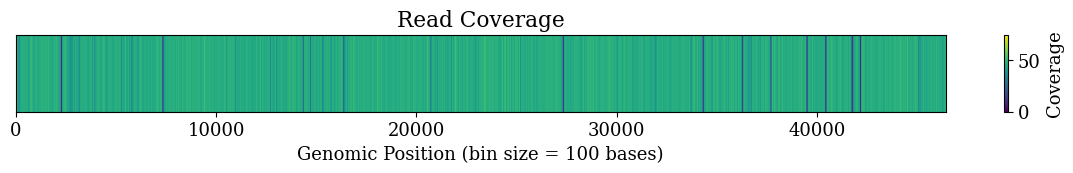

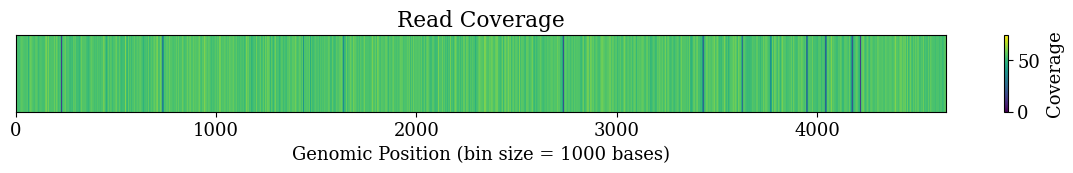

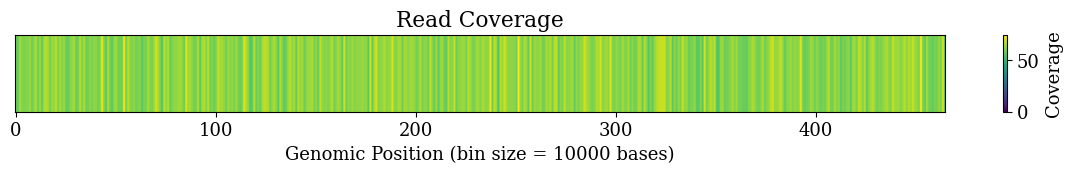

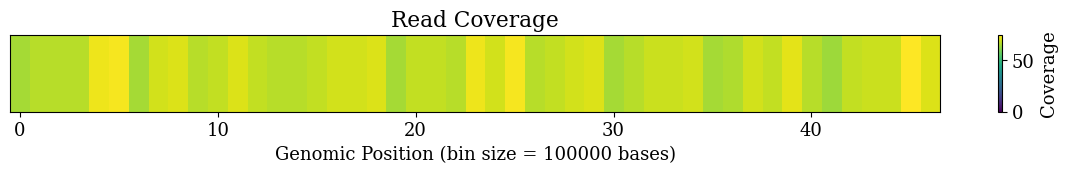

In [36]:
# Prepare read coverage array

cvg_arr = build_coverage_array(ref_path=os.path.join(REF_DIR, 'ecoli_ref.fa'), mapped_pairs=paired_exact_alns)
print(f'Min: {np.min(cvg_arr)}, Max: {np.max(cvg_arr)}')

plot_coverage_heatmap(cvg_arr, bin_size=100)
plot_coverage_heatmap(cvg_arr, bin_size=1000)
plot_coverage_heatmap(cvg_arr, bin_size=10000)
plot_coverage_heatmap(cvg_arr, bin_size=100000)

In [37]:
# Load gene expression file 

df_gene = pd.read_csv('/kaggle/input/mmr-gene-ecoli/final_ecoli.csv')
df_gene.head()

,Unnamed: 0,gene_id,start,end,expression,z_score,p_value,significant
0,0,gene-b0001,190,255,1095.808969,-0.131232,0.552204,False
1,1,gene-b0002,337,2799,11621.629880,0.319856,0.374539,False
2,2,gene-b0003,2801,3733,3581.617976,-0.024701,0.509853,False
3,3,gene-b0004,3734,5020,5462.200000,0.055892,0.477714,False
4,4,gene-b0005,5234,5530,204.196429,-0.169442,0.567275,False


In [38]:
# Now weighting unambiguous pairs 

with tqdm(total=len(paired_multi_alns)) as pbar:
    for pair in paired_multi_alns:
        r1_start, r1_end = pair['r1_start'], pair['r1_end']
        r2_start, r2_end = pair['r2_start'], pair['r2_end']
        start, end = min(r1_start, r2_start), max(r1_end, r2_end)

        scores = aggregate_region_stats_weighted(df_gene, start, end)

        if scores['total_overlap'] == 0 or pd.isna(scores['p_value']) or pd.isna(scores['z_score']):
            pair['p_val'] = np.nan
            pair['z_score'] = np.nan
        else:
            pair['p_val'] = scores['p_value']
            pair['z_score'] = scores['z_score']

        region = cvg_arr[start:end]  # adjust if needed
        pair['weight'] = np.mean(region) if len(region) > 0 else np.nan

        pbar.update(1)


  0%|          | 0/82805 [00:00<?, ?it/s]

In [39]:
# Print format

def ellipsize_middle(s, width):
    return s if len(s) <= width else s[: (width-3)//2] + "\n...\n" + s[-(width-3)//2:]

print(ellipsize_middle(str(paired_multi_alns[0]), 2000))

{'qname': 'NC_000913.3-1392422', 'chr': 'NC_000913.3', 'r1_start': 2727796, 'r1_end': 2727896, 'r2_start': 2727605, 'r2_end': 2727705, 'r1_mapq': 1, 'r2_mapq': 1, 'r1_flag': 83, 'r2_flag': 163, 'r1_is_reverse': True, 'r2_is_reverse': False, 'r1_primary': True, 'r2_primary': True, 'tfidf_k6': [0.017594139676488235, 0.020011562439716853, 0.017933702079178524, 0.01794552466657446, 0.0399258761542822, 0.02278390302462206, 0.025071846282542224, 0.027199990591284882, 0.023131891829902388, 0.018422016893120927, 0.04076062249605383, 0.04476911439268387, 0.024050726797319167, 0.024720469675587265, 0.021757012599372537, 0.01882670824569036, 0.017043659055551334, 0.01666171664281081, 0.017043404799140058, 0.017113111571752413, 0.01843740968159499, 0.017126575069131587, 0.022456878521344058, 0.018352778294561854, 0.02020842572276489, 0.01920955092526123, 0.019982465770521225, 0.017696898950664643, 0.015468313286419084, 0.020065671738169054, 0.01751462271613409, 0.017284624204201106, 0.0208161783
.

# Storing Data

In [40]:
# Flatten directly to DataFrame

df_full = pd.DataFrame(paired_multi_alns)
df_full.to_csv(os.path.join(DATA_DIR, "all.csv"), index=False)

In [41]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

def prepare_and_save_data(df, data_dir=DATA_DIR, seed=1234, embed_features=['tfidf_k6', 'tfidf_k7', 'tfidf_k8', 'tfidf_k9', 'tfidf_k10', 'tfidf_k11', 'tfidf_k12', 'tfidf_k13', 'tfidf_k14', 'tfidf_k15']):
    """
    Prepares dataset keeping all features intact (per dictionary):
      - numeric features scaled
      - categorical features one-hot encoded
      - NaNs in numeric columns filled with 0
      - saves train/val/test splits
    """
    # --- Features ---
    numeric_features = [
        'r1_start', 'r1_end', 'r1_mapq', 'r1_is_reverse', 
        'r2_start', 'r2_end', 'r2_mapq', 'r2_is_reverse', 
        'weight', 'p_val', 'z_score'
    ]
    categorical_features = ['chr', 'r1_flag', 'r2_flag']
    target = 'label'

    df[target] = df[target].astype(int)
    
    # Fill NaNs in numeric columns and p_val separately
    df[[f for f in numeric_features if f != 'p_val']] = df[[f for f in numeric_features if f != 'p_val']].fillna(0)
    df['p_val'] = df['p_val'].fillna(-1)
    
    # Convert booleans to int if not already
    df['r1_is_reverse'] = df['r1_is_reverse'].astype(int)
    df['r2_is_reverse'] = df['r2_is_reverse'].astype(int)
    df['bowtie'] = df['bowtie'].astype(int)

    # --- Expand embedding arrays into columns ---
    embed_cols = []
    for col in embed_features:
        emb_dim = len(df[col].iloc[0])   # dimension of embedding
        emb_df = pd.DataFrame(df[col].tolist(),
                              index=df.index,
                              columns=[f"{col}_{i}" for i in range(emb_dim)])
        df = pd.concat([df.drop(columns=[col]), emb_df], axis=1)
        embed_cols.extend(emb_df.columns.tolist())

    # --- Split train/val/test ---
    train_val_df, test_df = train_test_split(df, test_size=0.20, random_state=seed, stratify=df[target])
    train_df, val_df = train_test_split(train_val_df, test_size=0.125, random_state=seed, stratify=train_val_df[target])

    X_train = train_df[numeric_features + categorical_features + embed_cols + ['bowtie',]]
    y_train = train_df[target]
    X_val = val_df[numeric_features + categorical_features + embed_cols + ['bowtie',]]
    y_val = val_df[target]
    X_test = test_df[numeric_features + categorical_features + embed_cols + ['bowtie',]]
    y_test = test_df[target]

    # --- Preprocessing ---
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
        ],
        remainder='passthrough'
    )

    X_train_processed = preprocessor.fit_transform(X_train)
    X_val_processed = preprocessor.transform(X_val)
    X_test_processed = preprocessor.transform(X_test)

    # --- Feature names ---
    cat_feature_names = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
    feature_names = numeric_features + cat_feature_names + embed_cols + ['bowtie',]

    X_train_df = pd.DataFrame(X_train_processed, columns=feature_names, index=train_df.index)
    X_val_df = pd.DataFrame(X_val_processed, columns=feature_names, index=val_df.index)
    X_test_df = pd.DataFrame(X_test_processed, columns=feature_names, index=test_df.index)

    # --- Save ---
    seed_dir = os.path.join(data_dir, f'seed{seed}')
    os.makedirs(seed_dir, exist_ok=True)

    X_train_df.to_csv(os.path.join(seed_dir, 'x_train.csv'), index=False)
    X_val_df.to_csv(os.path.join(seed_dir, 'x_val.csv'), index=False)
    X_test_df.to_csv(os.path.join(seed_dir, 'x_test.csv'), index=False)
    y_train.to_csv(os.path.join(seed_dir, 'y_train.csv'), index=False)
    y_val.to_csv(os.path.join(seed_dir, 'y_val.csv'), index=False)
    y_test.to_csv(os.path.join(seed_dir, 'y_test.csv'), index=False)

    print(f"Saved into: {seed_dir}")
    print(f"Numeric features scaled: {numeric_features}")
    print(f"Categorical features one-hot encoded: {categorical_features}")
    print(f"Embedding features expanded: {embed_cols}")


In [42]:
# Prepare for random = 128

prepare_and_save_data(df_full.copy(), data_dir=DATA_DIR, seed=128)

Saved into: /kaggle/working/ecoli/data/seed128
Numeric features scaled: ['r1_start', 'r1_end', 'r1_mapq', 'r1_is_reverse', 'r2_start', 'r2_end', 'r2_mapq', 'r2_is_reverse', 'weight', 'p_val', 'z_score']
Categorical features one-hot encoded: ['chr', 'r1_flag', 'r2_flag']
Embedding features expanded: ['tfidf_k6_0', 'tfidf_k6_1', 'tfidf_k6_2', 'tfidf_k6_3', 'tfidf_k6_4', 'tfidf_k6_5', 'tfidf_k6_6', 'tfidf_k6_7', 'tfidf_k6_8', 'tfidf_k6_9', 'tfidf_k6_10', 'tfidf_k6_11', 'tfidf_k6_12', 'tfidf_k6_13', 'tfidf_k6_14', 'tfidf_k6_15', 'tfidf_k6_16', 'tfidf_k6_17', 'tfidf_k6_18', 'tfidf_k6_19', 'tfidf_k6_20', 'tfidf_k6_21', 'tfidf_k6_22', 'tfidf_k6_23', 'tfidf_k6_24', 'tfidf_k6_25', 'tfidf_k6_26', 'tfidf_k6_27', 'tfidf_k6_28', 'tfidf_k6_29', 'tfidf_k6_30', 'tfidf_k6_31', 'tfidf_k6_32', 'tfidf_k6_33', 'tfidf_k6_34', 'tfidf_k6_35', 'tfidf_k6_36', 'tfidf_k6_37', 'tfidf_k6_38', 'tfidf_k6_39', 'tfidf_k6_40', 'tfidf_k6_41', 'tfidf_k6_42', 'tfidf_k6_43', 'tfidf_k6_44', 'tfidf_k6_45', 'tfidf_k6_46', 'tfi

In [43]:
# Prepare for random = 256

prepare_and_save_data(df_full.copy(), data_dir=DATA_DIR, seed=256)

Saved into: /kaggle/working/ecoli/data/seed256
Numeric features scaled: ['r1_start', 'r1_end', 'r1_mapq', 'r1_is_reverse', 'r2_start', 'r2_end', 'r2_mapq', 'r2_is_reverse', 'weight', 'p_val', 'z_score']
Categorical features one-hot encoded: ['chr', 'r1_flag', 'r2_flag']
Embedding features expanded: ['tfidf_k6_0', 'tfidf_k6_1', 'tfidf_k6_2', 'tfidf_k6_3', 'tfidf_k6_4', 'tfidf_k6_5', 'tfidf_k6_6', 'tfidf_k6_7', 'tfidf_k6_8', 'tfidf_k6_9', 'tfidf_k6_10', 'tfidf_k6_11', 'tfidf_k6_12', 'tfidf_k6_13', 'tfidf_k6_14', 'tfidf_k6_15', 'tfidf_k6_16', 'tfidf_k6_17', 'tfidf_k6_18', 'tfidf_k6_19', 'tfidf_k6_20', 'tfidf_k6_21', 'tfidf_k6_22', 'tfidf_k6_23', 'tfidf_k6_24', 'tfidf_k6_25', 'tfidf_k6_26', 'tfidf_k6_27', 'tfidf_k6_28', 'tfidf_k6_29', 'tfidf_k6_30', 'tfidf_k6_31', 'tfidf_k6_32', 'tfidf_k6_33', 'tfidf_k6_34', 'tfidf_k6_35', 'tfidf_k6_36', 'tfidf_k6_37', 'tfidf_k6_38', 'tfidf_k6_39', 'tfidf_k6_40', 'tfidf_k6_41', 'tfidf_k6_42', 'tfidf_k6_43', 'tfidf_k6_44', 'tfidf_k6_45', 'tfidf_k6_46', 'tfi

In [44]:
# Prepare for random = 512

prepare_and_save_data(df_full.copy(), data_dir=DATA_DIR, seed=512)

Saved into: /kaggle/working/ecoli/data/seed512
Numeric features scaled: ['r1_start', 'r1_end', 'r1_mapq', 'r1_is_reverse', 'r2_start', 'r2_end', 'r2_mapq', 'r2_is_reverse', 'weight', 'p_val', 'z_score']
Categorical features one-hot encoded: ['chr', 'r1_flag', 'r2_flag']
Embedding features expanded: ['tfidf_k6_0', 'tfidf_k6_1', 'tfidf_k6_2', 'tfidf_k6_3', 'tfidf_k6_4', 'tfidf_k6_5', 'tfidf_k6_6', 'tfidf_k6_7', 'tfidf_k6_8', 'tfidf_k6_9', 'tfidf_k6_10', 'tfidf_k6_11', 'tfidf_k6_12', 'tfidf_k6_13', 'tfidf_k6_14', 'tfidf_k6_15', 'tfidf_k6_16', 'tfidf_k6_17', 'tfidf_k6_18', 'tfidf_k6_19', 'tfidf_k6_20', 'tfidf_k6_21', 'tfidf_k6_22', 'tfidf_k6_23', 'tfidf_k6_24', 'tfidf_k6_25', 'tfidf_k6_26', 'tfidf_k6_27', 'tfidf_k6_28', 'tfidf_k6_29', 'tfidf_k6_30', 'tfidf_k6_31', 'tfidf_k6_32', 'tfidf_k6_33', 'tfidf_k6_34', 'tfidf_k6_35', 'tfidf_k6_36', 'tfidf_k6_37', 'tfidf_k6_38', 'tfidf_k6_39', 'tfidf_k6_40', 'tfidf_k6_41', 'tfidf_k6_42', 'tfidf_k6_43', 'tfidf_k6_44', 'tfidf_k6_45', 'tfidf_k6_46', 'tfi